
# CTAO with Gammapy

Access and inspect CTAO data and instrument response functions (IRFs) using Gammapy.

## Introduction

The [Cherenkov Telescope Array Observatory (CTAO)](https://www.ctao.org/)_ is the next generation
ground-based observatory for gamma-ray astronomy. Gammapy is the core
library for the Cherenkov Telescope Array Observatory (CTAO) science tools
([2017ICRC…35..766D](https://ui.adsabs.harvard.edu/abs/2017ICRC...35..766D)_
and [CTAO Press
Release](https://www.ctao.org/news/ctao-adopts-the-gammapy-software-package-for-science-analysis/)_).

CTAO will start taking data in the coming years. For now, to learn how to
analyse CTAO data and to use Gammapy, if you are a member of the CTAO
consortium, you can use the simulated dataset from:

- the CTA first data challenge which ran in 2017 and 2018 (see [here](https://forge.in2p3.fr/projects/data-challenge-1-dc-1/wiki)_
  for CTAO members)
- the CTAO Science Data Challenge of 2024 (see [here](https://ctaoobservatory.sharepoint.com/:f:/r/sites/share-open-data/Shared%20Documents/Reference%20datasets/Internal%20Science%20Data%20Challenge?csf=1&web=1&e=gNuFzI)_
  for CTAO members)

Gammapy fully supports the FITS data formats (events, IRFs) used in CTA
1DC and SDC. The XML sky model format is not supported, but are also not needed
to analyse the data, you have to specify your model via the Gammapy YAML
model format, or Python code, as shown below.

You can also use Gammapy to simulate CTAO data and evaluate CTAO performance
using the CTAO response files. Two sets of responses are available for different
array layouts:

- the Omega configuration (prod3b, 2016):  https://zenodo.org/records/5163273,
- the Alpha configuration (prod5, 2021): https://zenodo.org/records/5499840.

They are all fully supported by Gammapy.


## Tutorial overview

This notebook shows how to access CTAO data and instrument response
functions (IRFs) using Gammapy, and gives some examples how to quick
look the content of CTAO files, especially to see the shape of CTAO IRFs.

At the end of the notebooks, we give several links to other tutorial
notebooks that show how to simulate CTAO data and how to evaluate CTAO
observability and sensitivity, or how to analyse CTAO data.

Note that the FITS data and IRF format currently used by CTAO is the one
documented at https://gamma-astro-data-formats.readthedocs.io/, and is
also used by H.E.S.S. and other Imaging Atmospheric Cherenkov Telescopes
(IACTs). So if you see other Gammapy tutorials using e.g. H.E.S.S.
example data, know that they also apply to CTAO, all you have to do is to
change the loaded data or IRFs to CTAO.

## Setup


In [1]:
import os
from pathlib import Path
from astropy import units as u

# %matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display
from gammapy.data import DataStore, EventList
from gammapy.irf import EffectiveAreaTable2D, load_irf_dict_from_file

## Check setup



In [2]:
from gammapy.utils.check import check_tutorials_setup

check_tutorials_setup()


System:

	python_executable      : /Users/tharacaba/miniconda3/envs/gammapy-1.3/bin/python 
	python_version         : 3.11.11    
	machine                : arm64      
	system                 : Darwin     


Gammapy package:

	version                : 1.3        
	path                   : /Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/gammapy 


Other packages:

	numpy                  : 2.1.3      
	scipy                  : 1.14.1     
	astropy                : 6.1.6      
	regions                : 0.10       
	click                  : 8.1.8      
	yaml                   : 6.0.2      
	IPython                : 8.27.0     
	jupyterlab             : 4.2.7      
	matplotlib             : 3.9.4      
	pandas                 : 2.2.3      
	healpy                 : 1.18.0     
	iminuit                : 2.30.1     
	sherpa                 : not installed 
	naima                  : 0.10.2     
	emcee                  : 3.1.6      
	corner                 : 2.2.3   

## CTA 1DC

The CTA first data challenge (1DC) ran in 2017 and 2018. It is described
in detail
[here](https://forge.in2p3.fr/projects/data-challenge-1-dc-1/wiki)_
and a description of the data and how to download it is
[here](https://forge.in2p3.fr/projects/data-challenge-1-dc-1/wiki#Data-access)_.

You should download `caldb.tar.gz` (1.2 MB), `models.tar.gz` (0.9
GB), `index.tar.gz` (0.5 MB), as well as optionally the simulated
survey data you are interested in: Galactic plane survey `gps.tar.gz`
(8.3 GB), Galactic center `gc.tar.gz` (4.4 MB), Extragalactic survey
`egal.tar.gz` (2.5 GB), AGN monitoring `agn.wobble.tar.gz` (4.7 GB).
After download, follow the instructions how to `untar` the files, and
set a `CTADATA` environment variable to point to the data.

**For convenience**, since the 1DC data files are large and not publicly
available to anyone, we have taken a tiny subset of the CTA 1DC data,
four observations with the southern array from the GPS survey, pointing
near the Galactic center, and **included them at `$GAMMAPY_DATA/cta-1dc`**
which you get via `gammapy download datasets`.

### Files

Next we will show a quick overview of the files and how to load them,
and some quick look plots showing the shape of the CTAO IRFs. How to do
CTAO simulations and analyses is shown in other tutorials, see links at
the end of this notebook.




In [3]:
!ls -1 $GAMMAPY_DATA/cta-1dc

!ls -1 $GAMMAPY_DATA/cta-1dc/data/baseline/gps

!ls -1 $GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h

!ls -1 $GAMMAPY_DATA/cta-1dc/index/gps

README.md
caldb
data
index
make.py
gps_baseline_110380.fits
gps_baseline_111140.fits
gps_baseline_111159.fits
gps_baseline_111630.fits
irf_file.fits
hdu-index.fits.gz
obs-index.fits.gz


The access to the IRFs files requires to define a `CALDB` environment
variable. We are going to define it only for this notebook so it won’t
overwrite the one you may have already defined.




In [4]:
os.environ["CALDB"] = os.environ["GAMMAPY_DATA"] + "/cta-1dc/caldb"

### Datastore

You can use the `~gammapy.data.DataStore` to load via the index files




In [5]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/cta-1dc/index/gps")
print(data_store)

Data store:
HDU index table:
BASE_DIR: /Users/tharacaba/Desktop/Tesis_2/gammapy-datasets/1.3/cta-1dc/index/gps
Rows: 24
OBS_ID: 110380 -- 111630
HDU_TYPE: [np.str_('aeff'), np.str_('bkg'), np.str_('edisp'), np.str_('events'), np.str_('gti'), np.str_('psf')]
HDU_CLASS: [np.str_('aeff_2d'), np.str_('bkg_3d'), np.str_('edisp_2d'), np.str_('events'), np.str_('gti'), np.str_('psf_3gauss')]


Observation table:
Observatory name: 'CTA first data challenge (1DC)'
Number of observations: 4



If you can’t download the index files, or got errors related to the data
access using them, you can generate the `DataStore` directly from the
event files.




In [6]:
path = Path(os.environ["GAMMAPY_DATA"]) / "cta-1dc/data"
paths = list(path.rglob("*.fits"))
data_store = DataStore.from_events_files(paths)
print(data_store)

data_store.obs_table[["OBS_ID", "GLON_PNT", "GLAT_PNT", "IRF"]]

observation = data_store.obs(110380)
print(observation)

Data store:
HDU index table:
BASE_DIR: .
Rows: 24
OBS_ID: 110380 -- 111630
HDU_TYPE: [np.str_('aeff'), np.str_('bkg'), np.str_('edisp'), np.str_('events'), np.str_('gti'), np.str_('psf')]
HDU_CLASS: [np.str_('aeff_2d'), np.str_('bkg_3d'), np.str_('edisp_2d'), np.str_('events'), np.str_('gti'), np.str_('psf_3gauss')]


Observation table:
Observatory name: 'N/A'
Number of observations: 4

Observation

	obs id            : 110380 
 	tstart            : 59235.50
	tstop             : 59235.52
	duration          : 1800.00 s
	pointing (icrs)   : 267.7 deg, -29.6 deg

	deadtime fraction : 2.0%



## Events

We can load events data via the data store and observation, or
equivalently via the `~gammapy.data.EventList` class by specifying the
EVENTS filename.

The quick-look `events.peek()` plot below shows that CTAO has a field
of view of a few degrees, and two energy thresholds, one significantly
below 100 GeV where the CTAO large-size telescopes (LSTs) detect events,
and a second one near 100 GeV where the mid-sized telescopes (MSTs)
start to detect events.

Note that most events are “hadronic background” due to cosmic ray
showers in the atmosphere that pass the gamma-hadron selection cuts for
this analysis configuration. Since this is simulated data, column
`MC_ID` is available that gives an emission component identifier code,
and the EVENTS header in `events.table.meta` can be used to look up
which `MC_ID` corresponds to which emission component.

Events can be accessed from the observation object like:



In [7]:
events = observation.events

Or read directly from an event file:




In [8]:
events = EventList.read(
    "$GAMMAPY_DATA/cta-1dc/data/baseline/gps/gps_baseline_110380.fits"
)

Here we print the data from the first 5 events listed in the table:




In [9]:
display(events.table[:5])

EVENT_ID,TIME,RA,DEC,ENERGY,DETX,DETY,MC_ID
,s,deg,deg,TeV,deg,deg,
uint32,float64,float32,float32,float32,float32,float32,int32
1,664502403.0454683,-92.63541,-30.514854,0.03902182,-0.9077294,-0.2727693,2
2,664502405.2579999,-92.64103,-28.262728,0.030796371,1.3443842,-0.2838398,2
3,664502408.8205513,-93.20372,-28.599625,0.04009629,1.0049409,-0.7769775,2
4,664502409.0143764,-94.03383,-29.269627,0.039580025,0.32684833,-1.496021,2
5,664502414.8090746,-93.330505,-30.319725,0.03035851,-0.716062,-0.8733348,2


And show a summary plot:




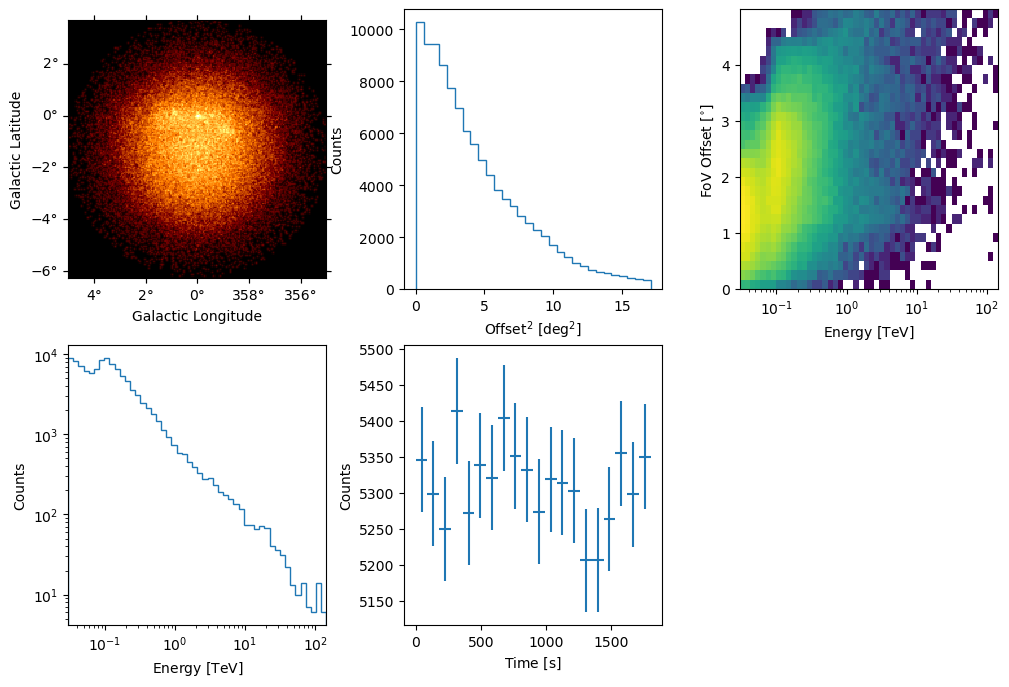

In [10]:
events.peek()
plt.show()

## IRFs

The CTAO instrument response functions (IRFs) are given as FITS files in
the `caldb` folder, the following IRFs are available:

-  effective area
-  energy dispersion
-  point spread function
-  background

Notes:

-  The IRFs contain the energy and offset dependence of the CTAO response
-  CTA 1DC was based on an early version of the CTAO FITS responses
   produced in 2017, improvements have been made since.
-  The point spread function was approximated by a Gaussian shape
-  The background is from hadronic and electron air shower events that
   pass CTAO selection cuts. It was given as a function of field of view
   coordinates, although it is radially symmetric.
-  The energy dispersion in CTA 1DC is noisy at low energy, leading to
   unreliable spectral points for some analyses.
-  The CTA 1DC response files have the first node at field of view
   offset 0.5 deg, so to get the on-axis response at offset 0 deg,
   Gammapy has to extrapolate. Furthermore, because diffuse gamma-rays
   in the FOV were used to derive the IRFs, and the solid angle at small
   FOV offset circles is small, the IRFs at the center of the FOV are
   somewhat noisy. This leads to unstable analysis and simulation issues
   when using the DC1 IRFs for some analyses.




In [11]:
print(observation.aeff)

irf_filename = (
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)
irfs = load_irf_dict_from_file(irf_filename)
print(irfs)

Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


EffectiveAreaTable2D
--------------------

  axes  : ['energy_true', 'offset']
  shape : (42, 6)
  ndim  : 2
  unit  : m2
  dtype : >f4

{'aeff': <gammapy.irf.effective_area.EffectiveAreaTable2D object at 0x168d69750>, 'psf': <gammapy.irf.psf.parametric.EnergyDependentMultiGaussPSF object at 0x16834a4d0>, 'edisp': <gammapy.irf.edisp.core.EnergyDispersion2D object at 0x168c053d0>, 'bkg': <gammapy.irf.background.Background3D object at 0x156a35050>}


### Effective area




EffectiveAreaTable2D
--------------------

  axes  : ['energy_true', 'offset']
  shape : (42, 6)
  ndim  : 2
  unit  : m2
  dtype : >f4



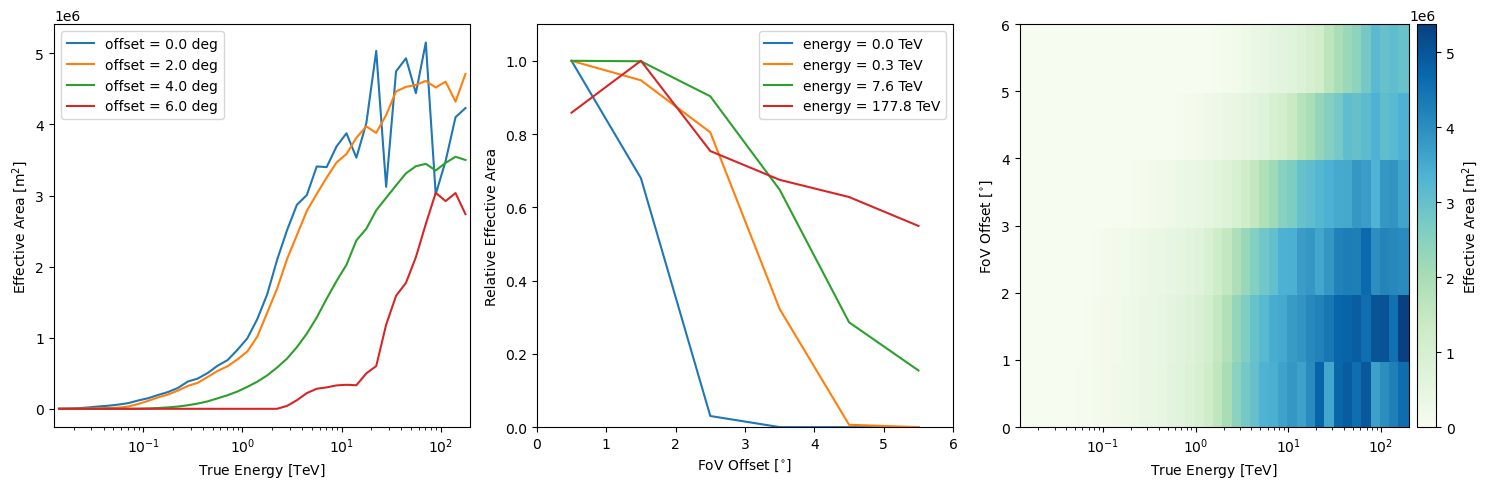

3.783587001383003 km2


In [12]:
# Equivalent alternative way to load IRFs directly
aeff = EffectiveAreaTable2D.read(irf_filename, hdu="EFFECTIVE AREA")
print(aeff)

irfs["aeff"].peek()
plt.show()

# What is the on-axis effective area at 10 TeV?
print(aeff.evaluate(energy_true="10 TeV", offset="0 deg").to("km2"))

### Energy dispersion




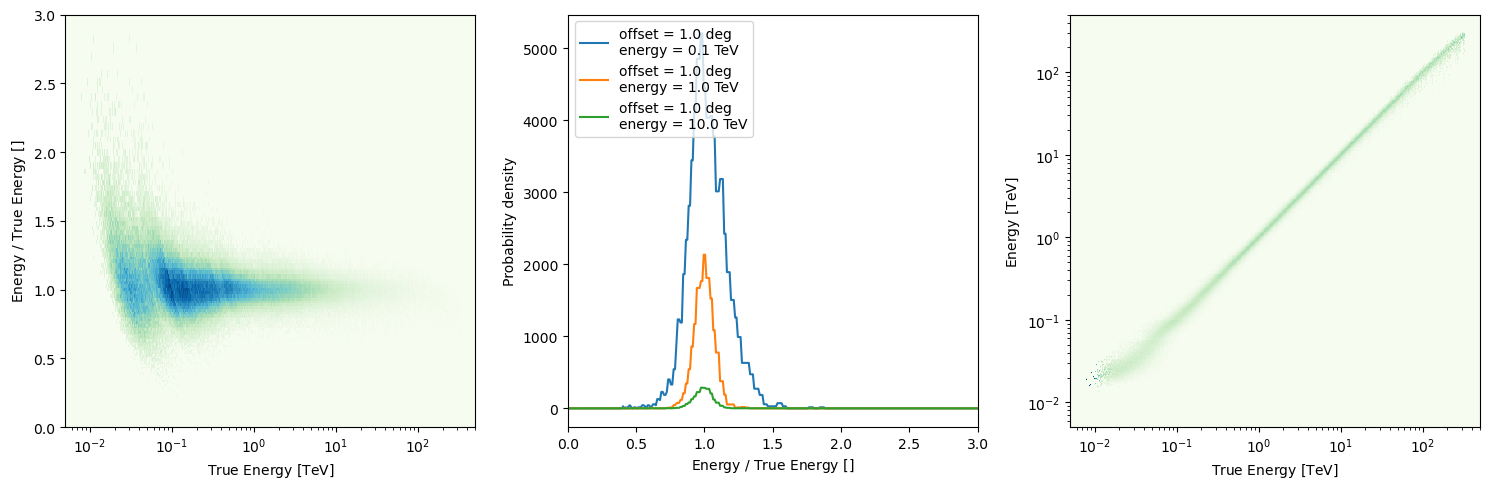

In [13]:
irfs["edisp"].peek()
plt.show()

### Point spread function




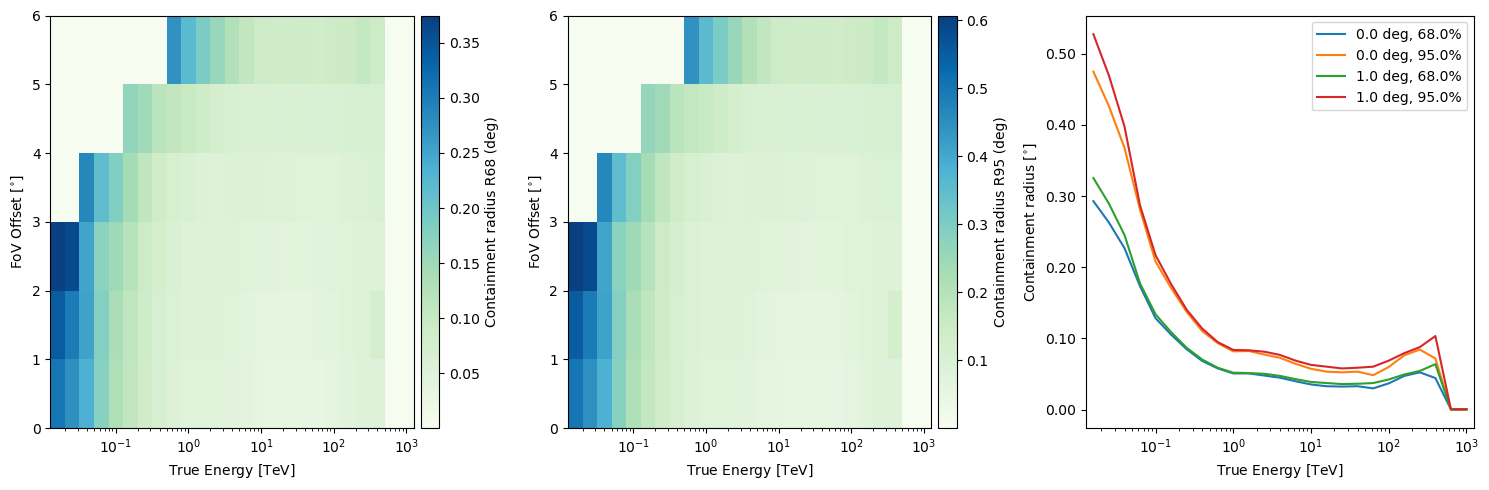

In [14]:
irfs["psf"].peek()
plt.show()

This is how for analysis you could slice out the PSF
at a given field of view offset



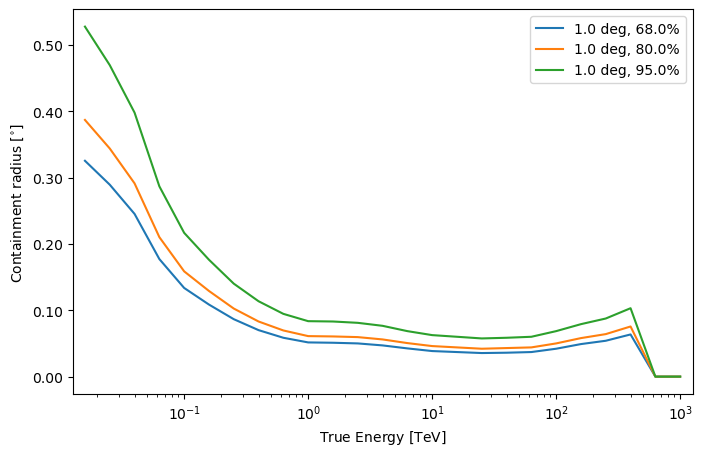

In [15]:
plt.figure(figsize=(8, 5))
irfs["psf"].plot_containment_radius_vs_energy(
    offset=[1] * u.deg, fraction=[0.68, 0.8, 0.95]
)
plt.show()

### Background

The background is given as a rate in units `MeV-1 s-1 sr-1`.




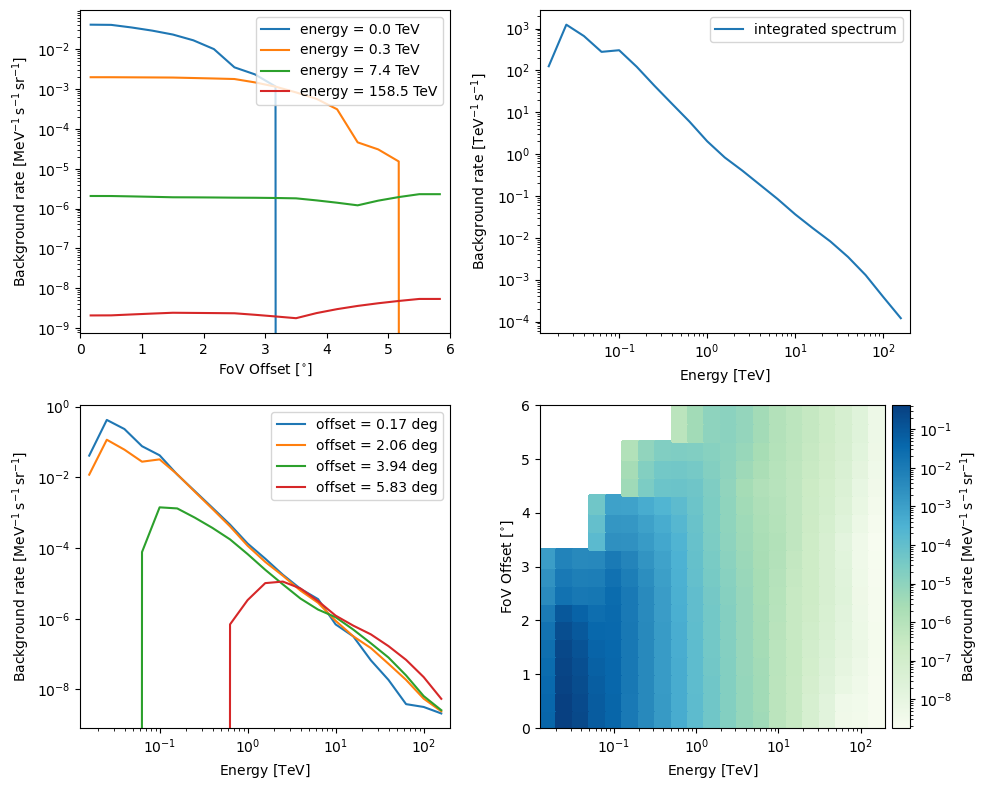

1.2053318160797465e-05 1 / (MeV s sr)


In [16]:
irfs["bkg"].peek()
plt.show()

print(irfs["bkg"].evaluate(energy="3 TeV", fov_lon="1 deg", fov_lat="0 deg"))

To visualise the background at particular energies:




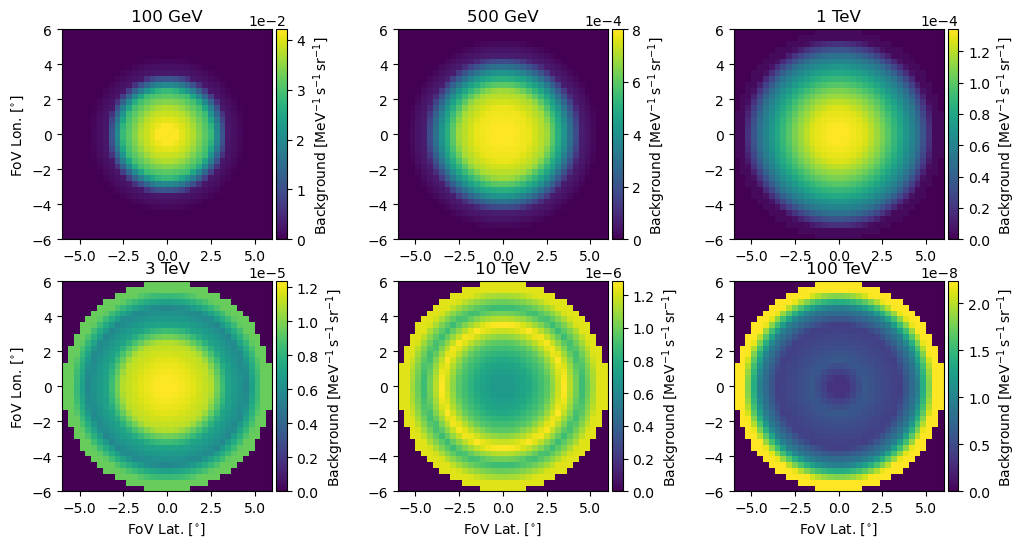

In [17]:
irfs["bkg"].plot_at_energy(
    ["100 GeV", "500 GeV", "1 TeV", "3 TeV", "10 TeV", "100 TeV"]
)
plt.show()

## Source models

The 1DC sky model is distributed as a set of XML files, which in turn
link to a ton of other FITS and text files. Gammapy doesn’t support this
XML model file format. We are currently developing a YAML based format
that improves upon the XML format, to be easier to write and read, add
relevant information (units for physical quantities), and omit useless
information (e.g. parameter scales in addition to values).

If you must or want to read the XML model files, you can use
e.g. [ElementTree](https://docs.python.org/3/library/xml.etree.elementtree.html)_
from the Python standard library, or
[xmltodict](https://github.com/martinblech/xmltodict)_ if you
`pip install xmltodict`. Here’s an example how to load the information
for a given source, and to convert it into the sky model format Gammapy
understands.




In [18]:
# This is what the XML file looks like
# !tail -n 20 $CTADATA/models/models_gps.xml

# TODO: write this example!

# Read XML file and access spectrum parameters
# from gammapy.extern import xmltodict

# filename = os.path.join(os.environ["CTADATA"], "models/models_gps.xml")
# data = xmltodict.parse(open(filename).read())
# data = data["source_library"]["source"][-1]
# data = data["spectrum"]["parameter"]
# data

# Create a spectral model the the right units
# from astropy import units as u
# from gammapy.modeling.models import PowerLawSpectralModel

# par_to_val = lambda par: float(par["@value"]) * float(par["@scale"])
# spec = PowerLawSpectralModel(
#     amplitude=par_to_val(data[0]) * u.Unit("cm-2 s-1 MeV-1"),
#     index=par_to_val(data[1]),
#     reference=par_to_val(data[2]) * u.Unit("MeV"),
# )
# print(spec)

## Latest CTAO performance files

CTA 1DC is useful to learn how to analyse CTAO data. But to do
simulations and studies for CTAO now, you should get the most recent CTAO
IRFs in FITS format from https://www.ctao.org/for-scientists/performance/.

If you want to use other response files, the following code cells (remove the # to uncomment)
explain how to proceed. This example is made with the Alpha configuration (Prod5).




In [19]:
# !curl -o cta-prod5-zenodo-fitsonly-v0.1.zip https://zenodo.org/records/5499840/files/cta-prod5-zenodo-fitsonly-v0.1.zip
# !unzip cta-prod5-zenodo-fitsonly-v0.1.zip
# !ls fits/

# !tar xf fits/CTA-Performance-prod5-v0.1-South-40deg.FITS.tar.gz -C fits/.
# !ls fits/*.fits.gz

# irfs1 = load_irf_dict_from_file("fits/Prod5-South-40deg-SouthAz-14MSTs37SSTs.180000s-v0.1.fits.gz")
# irfs1["aeff"].plot_energy_dependence()

# irfs2 = load_irf_dict_from_file("fits/Prod5-South-40deg-SouthAz-14MSTs37SSTs.1800s-v0.1.fits.gz")
# irfs2["aeff"].plot_energy_dependence()

## Exercises

-  Load the EVENTS file for `obs_id=111159` as a
   `~gammapy.data.EventList` object.
-  Use `~gammapy.data.EventList.table` to find the energy, sky coordinate and time of
   the highest-energy event.
-  Use `~gammapy.data.EventList.pointing_radec` to find the pointing position of this
   observation, and use `astropy.coordinates.SkyCoord` methods to find
   the field of view offset of the highest-energy event.
-  What is the effective area and PSF 68% containment radius of CTAO at 1
   TeV for the `South_z20_50h` configuration used for the CTA 1DC
   simulation?
-  Get the latest CTAO FITS performance files from
   https://www.ctao.org/for-scientists/performance/ and run the
   code example above. Make an effective area ratio plot of 40 deg
   zenith versus 20 deg zenith for the `South_z40_50h` and
   `South_z20_50h` configurations.




In [20]:
from gammapy.data import EventList
from astropy.coordinates import SkyCoord
import astropy.units as u

# Load the event list
events = EventList.read("$GAMMAPY_DATA/cta-1dc/data/baseline/gps/gps_baseline_111159.fits")
table = events.table

# Find the index of the highest-energy event
max_idx = table['ENERGY'].argmax()

# Access the event row
event = table[max_idx]

# Print the event values
print("Highest energy event:")
print(f"  ENERGY : {event['ENERGY']:.4f} TeV")
print(f"  TIME   : {event['TIME']:.6f} s")
print(f"  RA     : {event['RA']:.5f} deg")
print(f"  DEC    : {event['DEC']:.5f} deg")

# Create SkyCoord for the event
event_coord = SkyCoord(ra=event['RA'] * u.deg, dec=event['DEC'] * u.deg, frame="icrs")

# Get pointing direction of the observation
pointing_coord = events.pointing_radec

print(f"Pointing position:")
print(f"  RA     : {pointing_coord.ra:.5f}")
print(f"  DEC    : {pointing_coord.dec:.5f}")

# Calculate offset (angular separation)
offset = event_coord.separation(pointing_coord)

print(f"Field of view offset of the highest-energy event: {offset:.4f}")

Highest energy event:
  ENERGY : 159.2164 TeV
  TIME   : 668046391.883750 s
  RA     : -94.41589 deg
  DEC    : -25.74306 deg
Pointing position:
  RA     : 266.03671 deg
  DEC    : -26.97820 deg
Field of view offset of the highest-energy event: 1.3000 deg


In [23]:
from astropy import units as u
from gammapy.irf import EffectiveAreaTable2D, load_irf_dict_from_file

# Path to the IRF file (change if yours is named differently)
irf_filename = "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"

# Load the IRFs as a dictionary
irfs = load_irf_dict_from_file(irf_filename)

# Extract Effective Area and PSF IRFs
aeff = irfs["aeff"]
psf = irfs["psf"]

# Define energy and offset
energy = 1 * u.TeV
offset = 0.5 * u.deg  # Use 0.5 deg since 0 deg is extrapolated and noisy in 1DC IRFs

# Evaluate Effective Area
aeff_value = aeff.evaluate(energy_true=energy, offset=offset)
print(f"Effective Area at 1 TeV and 0.5° offset: {aeff_value.to('m2'):.2f}")

# Evaluate PSF 68% containment radius
# Use axis names instead of energy and offset keywords
psf_radius = psf.containment_radius(
    fraction=0.68,
    energy_true=energy,
    offset=offset
)

print(f"PSF 68% containment radius at 1 TeV and 0.5° offset: {psf_radius.to('deg'):.4f}")

Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


Effective Area at 1 TeV and 0.5° offset: 884833.97 m2
PSF 68% containment radius at 1 TeV and 0.5° offset: 0.0513 deg


<Axes: xlabel='True Energy [$\\mathrm{TeV}$]', ylabel='Effective Area [$\\mathrm{m^{2}}$]'>

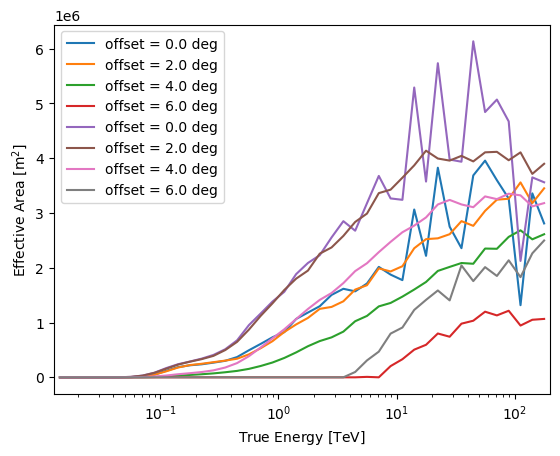

In [24]:
irfs1 = load_irf_dict_from_file("/Users/tharacaba/Desktop/Tesis_2/gammapy-datasets/1.3/cta-prod5-zenodo-fitsonly-v0/fits/CTA-Performance-prod5-v0.1-South-40deg.FITS/Prod5-South-40deg-SouthAz-14MSTs37SSTs.180000s-v0.1.fits.gz")
irfs1["aeff"].plot_energy_dependence()

irfs2 = load_irf_dict_from_file("/Users/tharacaba/Desktop/Tesis_2/gammapy-datasets/1.3/cta-prod5-zenodo-fitsonly-v0/fits/CTA-Performance-prod5-v0.1-South-40deg.FITS/Prod5-South-40deg-SouthAz-14MSTs37SSTs.1800s-v0.1.fits.gz")
irfs2["aeff"].plot_energy_dependence()

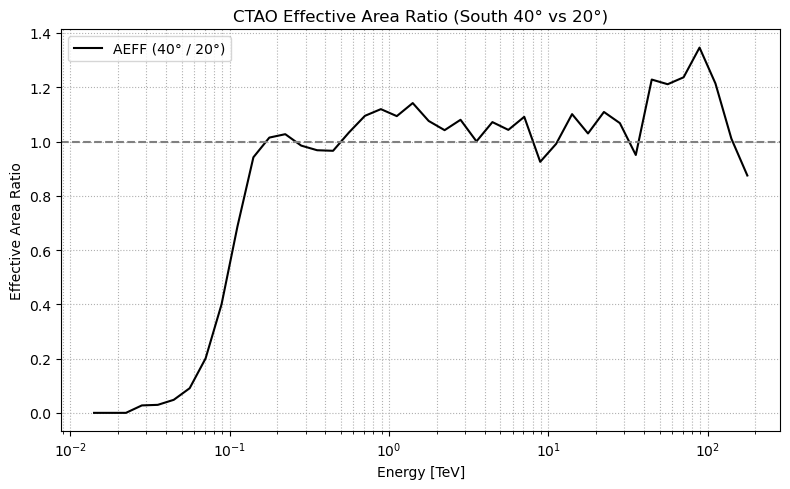

In [25]:
from gammapy.irf import EffectiveAreaTable2D
import matplotlib.pyplot as plt
import astropy.units as u

# Path to the IRF files you extracted
path_20 = "/Users/tharacaba/Desktop/Tesis_2/gammapy-datasets/1.3/cta-prod5-zenodo-fitsonly-v0/fits/CTA-Performance-prod5-v0.1-South-20deg.FITS/Prod5-South-20deg-AverageAz-14MSTs37SSTs.180000s-v0.1.fits"
path_40 = "/Users/tharacaba/Desktop/Tesis_2/gammapy-datasets/1.3/cta-prod5-zenodo-fitsonly-v0/fits/CTA-Performance-prod5-v0.1-South-40deg.FITS/Prod5-South-40deg-AverageAz-14MSTs37SSTs.180000s-v0.1.fits"

# Load effective areas
aeff_20 = EffectiveAreaTable2D.read(path_20, hdu="EFFECTIVE AREA")
aeff_40 = EffectiveAreaTable2D.read(path_40, hdu="EFFECTIVE AREA")

# Define a fixed offset (must match one of the available nodes)
offset = 0.5 * u.deg

# Evaluate effective area curves at the same offset
energy = aeff_20.axes["energy_true"].center

aeff_val_20 = aeff_20.evaluate(energy_true=energy, offset=offset)
aeff_val_40 = aeff_40.evaluate(energy_true=energy, offset=offset)

# Compute ratio
ratio = aeff_val_40 / aeff_val_20

# Plot
plt.figure(figsize=(8, 5))
plt.plot(energy, ratio, label="AEFF (40° / 20°)", color="black")
plt.axhline(1, color="gray", linestyle="--")
plt.xscale("log")
plt.xlabel("Energy [TeV]")
plt.ylabel("Effective Area Ratio")
plt.title("CTAO Effective Area Ratio (South 40° vs 20°)")
plt.legend()
plt.grid(True, which="both", linestyle=":")
plt.tight_layout()
plt.show()


## Next steps

-  Learn how to analyse data with
   :doc:`/tutorials/starting/analysis_1` and
   :doc:`/tutorials/starting/analysis_2` or any other
   Gammapy analysis tutorial.
-  Learn how to evaluate CTAO observability and sensitivity with
   :doc:`/tutorials/analysis-3d/simulate_3d`,
   :doc:`/tutorials/analysis-1d/spectrum_simulation`
   or :doc:`/tutorials/analysis-1d/cta_sensitivity`.


